In [1]:
# downloaded: ipykernel, jupyterlab, notebook, scipy, requests, pytz, seaborn, plotly, h5py
# Core libraries
import os, time, gc, itertools, pickle, psutil
from collections import OrderedDict, defaultdict
from tqdm import tqdm
# Scientific and Data libraries
import numpy as np, pandas as pd
from scipy.stats import fisher_exact, ttest_1samp, norm
# Plotting libraries
import seaborn as sns, matplotlib.pyplot as plt
import plotly.express as px, plotly.graph_objs as go, plotly.offline as py
# Bioinformatics libraries
from Bio.Seq import Seq
from Bio import SeqIO
from skbio.alignment import StripedSmithWaterman
import pybedtools, logomaker
pybedtools.set_bedtools_path("/opt/packages/bedtools/2.30.0") #### Required so that it can find the bedtools executable
# PyTorch libraries
import torch
import torch.nn.functional as F
# Multiprocessing
from multiprocessing import Pool, cpu_count
# h5py for handling HDF5 files
import h5py


In [11]:
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'ce_seek_1')
output_file = f"{out_path}/out_files/concatenated_file.txt"
# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [3]:
from motif_analysis_utility import *
from gimmemotifs.motif import default_motifs

In [4]:
class MotifProcessor:
    ########################################################################################################
    #### Codes Related to Motif Processing ####
    ########################################################################################################
    def __init__(self):
        self.motif_pwm_path = None
        self.dict_motif = None
        self.dict_motif_cutoff = None
        self.sequences = None
        self.sequence_names = None
        self.sequence_file_fa = None
        self.sequence_file_bed = None
        self.sequences_control = None
        # self.sequence_control_file_fa = None
        # self.sequence_control_file_bed = None
        self.sequence_length = None
        self.motif_hits = None
        self.dict_motif_hits = None
        self.dict_motif_hits_control = None
        self.species = "Human"

        # if motif_pwm_path is not None:
        #     self.motif_pwm_path = motif_pwm_path
        #     self.dict_motif, self.dict_motif_cutoff = self.read_motif_pwm()
        #     motif_filters = []
        #     for pwm in self.dict_motif.values():
        #         pwm = np.array(pwm) + 0.001
        #         pwm = pwm / pwm.sum(axis=1, keepdims=True)
        #         pwm = np.log2(pwm / 0.25)
        #         motif_filters.append(pwm)
        #     motif_length_max = max([pwm.shape[0] for pwm in motif_filters])
        #     for ind, pwm in enumerate(motif_filters):
        #         zero_padding_length = motif_length_max - pwm.shape[0]
        #         motif_filters[ind] = np.vstack((
        #             np.zeros((int(zero_padding_length / 2), 4)),
        #             pwm,
        #             np.zeros((zero_padding_length - int(zero_padding_length / 2), 4))
        #         ))
        #     self.motif_filters = np.array(motif_filters, dtype=float)
        #     self.motif_cutoffs = np.array(list(self.dict_motif_cutoff.values()))

    def process_custom_motif_pwm(self):
        dict_motif = OrderedDict()
        dict_motif_cutoff = OrderedDict()
        motif_name = None
        if os.path.isfile(self.motif_pwm_path):
            with open(self.motif_pwm_path, 'r') as infile:
                for line in infile:
                    if line.startswith('>'):
                        if motif_name is not None:
                            dict_motif[motif_name] = np.array(motif_pwm)
                        motif_name = line.strip().split('\t')[1]
                        motif_pwm = []
                        try:
                            dict_motif_cutoff[motif_name] = float(line.strip().split('\t')[2])
                        except:
                            dict_motif_cutoff[motif_name] = -np.inf
                    else:
                        motif_pwm.append(list(map(float, line.strip().split('\t'))))
                dict_motif[motif_name] = np.array(motif_pwm)
        else:
            for motif_file in os.listdir(self.motif_pwm_path):
                with open("%s/%s" % (self.motif_pwm_path, motif_file), 'r') as infile:
                    for line in infile:
                        if line.startswith('>'):
                            if motif_name is not None:
                                dict_motif[motif_name] = np.array(motif_pwm)
                            motif_name = line.strip().split('\t')[1]
                            motif_pwm = []
                            try:
                                dict_motif_cutoff[motif_name] = float(line.strip().split('\t')[2])
                            except:
                                dict_motif_cutoff[motif_name] = -np.inf
                        else:
                            motif_pwm.append(list(map(float, line.strip().split('\t'))))
                    dict_motif[motif_name] = np.array(motif_pwm)
        
        for motif in dict_motif.keys():
            dict_motif[motif] = np.array(dict_motif[motif], dtype=float)
        return dict_motif, dict_motif_cutoff

    def process_default_motif_pwm(self, motifs):
        dict_motif = OrderedDict()
        for motif in motifs:
            dict_motif[motif.id] = np.array(motif.pwm, dtype=float)
        return dict_motif

    def create_motif_filters_and_cutoffs(self, dict_motif, dict_motif_cutoff):
        motif_filters = []
        for pwm in dict_motif.values():
            pwm = np.array(pwm) + 0.001
            pwm = pwm / pwm.sum(axis=1, keepdims=True)
            pwm = np.log2(pwm / 0.25)
            motif_filters.append(pwm)
        motif_length_max = max([pwm.shape[0] for pwm in motif_filters])
        for ind, pwm in enumerate(motif_filters):
            zero_padding_length = motif_length_max - pwm.shape[0]
            motif_filters[ind] = np.vstack((
                np.zeros((int(zero_padding_length / 2), 4)),
                pwm,
                np.zeros((zero_padding_length - int(zero_padding_length / 2), 4))
            ))
        return np.array(motif_filters, dtype=float), np.array(list(dict_motif_cutoff.values()))
    
    def set_motifs(self, motif_pwm_path = None, TF_formatting="auto", verbose=True):
        if motif_pwm_path is None:
            if verbose:
                print("No motif pwm path entered. Loading default motifs for your species ...")

            if self.species in ["Mouse", "Human", "Rat"]: # If species is vertebrate, we use gimmemotif default motifs as a default.
                motifs = default_motifs()
                self.motif_pwm_path = None
                dict_motif, dict_motif_cutoff = self.process_default_motif_pwm(motifs)
                self.motif_db_name = "gimme.vertebrate.v5.0"
                self.TF_formatting = True
                if verbose:
                    print(" Default motif for vertebrate: gimme.vertebrate.v5.0. \n For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html \n")
            else:
                raise ValueError(f"We don't have default motifs for your species, Please provide motif PWM path")

        else:
            if verbose:
                print("Custom motif data entered. Processing ...")
            self.motif_pwm_path = motif_pwm_path
            dict_motif, dict_motif_cutoff = self.process_custom_motif_pwm()
            self.motif_db_name = "custom_motifs"
            if TF_formatting == "auto":
                self.TF_formatting = False
            else:
                self.TF_formatting = TF_formatting
        self.dict_motif, self.dict_motif_cutoff = dict_motif, dict_motif_cutoff
        # self.motif_filters, self.motif_cutoffs = self.create_motif_filters()
        return None
    
    def get_motif_hits(self, list_seq, dict_motif, motif_filters, motif_cutoffs, strand="+", start_index=0, percentile_cutoff=.90, device=None, num_threads=None):
        device = set_device_and_threads(device,num_threads)

        motif_cutoffs = torch.from_numpy(motif_cutoffs).to(device)
        motif_cutoffs = motif_cutoffs.view(1, -1, 1)
        motif_filters = torch.from_numpy(motif_filters).unsqueeze(1).float().to(device)

        if strand == "+":
            seq_onehot = one_hot4seqs(list_seq)
        else:
            seq_onehot = one_hot4seqs([get_reverse_complement(seq) for seq in list_seq])
        
        seq_onehot = seq_onehot.permute((0, 2, 1)).unsqueeze(1).float().to(device)
        seq_onehot.share_memory_()
        # scores dim: [N_seq, N_motif, N_length, 1]
        # print(seq_onehot.shape, motif_filters.shape)
        # print(seq_onehot)
        scores = torch.nn.functional.conv2d(seq_onehot, motif_filters, padding=0, stride=1, groups=1)
        scores = scores.squeeze(3)

        scores_max = scores.max(dim=2).values  # Shape: (N_seq, N_motif)
        percentile = torch.quantile(scores_max, percentile_cutoff, dim=0, interpolation='linear')  # Shape: (N_motif,)
        self.percentile = percentile

        binary_matrix = scores >= motif_cutoffs
        # N_seq, N_motif, N_length = binary_matrix.shape
        hit_indices = torch.nonzero(binary_matrix)
        #         self.hit_indices = hit_indices

        if strand == "+":
            pseudo_index = (start_index + hit_indices[:, 0]) * (2 * self.sequence_length) + hit_indices[:, 2]
        else:
            pseudo_index = (start_index + hit_indices[:, 0]) * (2 * self.sequence_length) + binary_matrix.shape[2] - hit_indices[:, 2]

        list_pseudo_indices, list_motif_cutoffs = [], []
        # Convert the indices to pseudo-indices
        for motif_ind, motif_name in enumerate(dict_motif):
            mask = (hit_indices[:, 1] == motif_ind)
            zero_padding_length = motif_filters.shape[1] - dict_motif[motif_name].shape[0]
            if strand == "+":
                list_pseudo_indices.append((pseudo_index[mask].cpu().numpy() + int(zero_padding_length / 2)).tolist())
            else:
                list_pseudo_indices.append((pseudo_index[mask].cpu().numpy() + zero_padding_length - int(zero_padding_length / 2) - 1).tolist())
            list_motif_cutoffs.append(percentile[motif_ind].cpu().item())  # Store the cutoff for this motif
        if device == 'cuda':
            torch.cuda.empty_cache()

        return list_pseudo_indices, list_motif_cutoffs
       
    def load_sequences(self, input_file, sequence_set=None, genome_sequence_fa=None, fasta_input=False,
                       out_seq_len=300):
        assert sequence_set in (None, "control", 'target')

        self.sequence_length = out_seq_len
        if fasta_input:
            list_seq = list(read_fasta(input_file).values())
            list_seq_names = list(read_fasta(input_file).keys())
        else:
            assert genome_sequence_fa is not None, "Please provide genome_sequence_fa"
            list_seq,list_seq_names = get_bed_peak_sequence(input_file, genome_sequence_fa, return_seq_name=True)
        # extend or subset from the center of the sequence to the same length
        for ind, seq in enumerate(list_seq):
            if len(seq) < out_seq_len:
                list_seq[ind] = seq + 'N' * (out_seq_len - len(seq))
            elif len(seq) > out_seq_len:
                list_seq[ind] = seq[(len(seq) - out_seq_len) // 2:(len(seq) + out_seq_len) // 2]
        if sequence_set == 'control':
            self.sequences_control = list_seq
            # if fasta_input:
            #     self.sequence_control_file_fa = input_file
            # else:
            #     self.sequence_control_file_bed = input_file
        else:
            self.sequences = list_seq
            self.sequence_names = list_seq_names
            if fasta_input:
                self.sequence_file_fa = input_file
            else:
                self.sequence_file_bed = input_file
        return None

    def scan_motif_on_batch_sequences(self, list_seq, num_threads=1, batch_max_number=1e7):

        batch_seq_size = int(batch_max_number / self.motif_filters.shape[0] / 2)

        dict_motif_hits = OrderedDict()

        for i in range(0, len(list_seq), batch_seq_size):
            list_seq_batch = list_seq[i:(i + batch_seq_size)]
            for strand in ["+", "-"]:
                list_pseudo_indices, _ = self.get_motif_hits(list_seq_batch, self.motif_filters, self.motif_cutoffs, strand=strand,
                                                          start_index=i, num_threads=num_threads)
                for motif_ind, motif_name in enumerate(self.dict_motif):
                    if motif_name not in dict_motif_hits:
                        dict_motif_hits[motif_name] = {}
                        dict_motif_hits[motif_name]['+'] = []
                        dict_motif_hits[motif_name]['-'] = []
                    dict_motif_hits[motif_name][strand] += list_pseudo_indices[motif_ind]

        # self.dict_motif_hits = dict_motif_hits
        return dict_motif_hits
    
    def scan_motif_on_sequences(self, list_seq, batch_max_number=1e7, **kwargs):
        dict_motif = self.dict_motif
        dict_motif_cutoff = self.dict_motif_cutoff
        motif_filters, motif_cutoffs = self.create_motif_filters_and_cutoffs(dict_motif, dict_motif_cutoff)
        batch_seq_size = int(batch_max_number / motif_filters.shape[0] / 2)
        dict_motif_hits = OrderedDict()

        for i in range(0, len(list_seq), batch_seq_size):
            list_seq_batch = list_seq[i:(i + batch_seq_size)]
            for strand in ["+", "-"]:
                list_pseudo_indices, _ = self.get_motif_hits(list_seq_batch, dict_motif, motif_filters, motif_cutoffs, 
                                                             strand=strand, start_index=i, **kwargs)
                for motif_ind, motif_name in enumerate(dict_motif.keys()):
                    if motif_name not in dict_motif_hits:
                        dict_motif_hits[motif_name] = {}
                        dict_motif_hits[motif_name]['+'] = []
                        dict_motif_hits[motif_name]['-'] = []
                    dict_motif_hits[motif_name][strand] += list_pseudo_indices[motif_ind]

        # self.dict_motif_hits = dict_motif_hits
        return dict_motif_hits
    
    def calculate_homer_score_for_motifs(self, list_seq, batch_max_number=1e7, **kwargs):
        mask = np.array(list(self.dict_motif_cutoff.values())) == -np.inf
        keys = np.array(list(self.dict_motif.keys()))[mask]
        
        dict_motif = OrderedDict((k, self.dict_motif[k]) for k in keys)
        dict_motif_cutoff = OrderedDict((k, -np.inf) for k in keys)
        motif_filters, motif_cutoffs = self.create_motif_filters_and_cutoffs(dict_motif, dict_motif_cutoff)
        self.motifs_with_no_scores=list(dict_motif.keys())

        batch_seq_size = int(batch_max_number / motif_filters.shape[0] / 2)

        dict_motif_cutoffs = OrderedDict()

        for i in range(0, len(list_seq), batch_seq_size):
            list_seq_batch = list_seq[i:(i + batch_seq_size)]
            for strand in ["+", "-"]:
                _, list_motif_cutoffs = self.get_motif_hits(list_seq_batch, dict_motif, motif_filters, motif_cutoffs,
                                                            strand=strand, start_index=i, **kwargs)
                for motif_ind, motif_name in enumerate(dict_motif.keys()):
                    if motif_name not in dict_motif_cutoffs:
                        dict_motif_cutoffs[motif_name] = {}
                        dict_motif_cutoffs[motif_name]['+'] = []
                        dict_motif_cutoffs[motif_name]['-'] = []
                    dict_motif_cutoffs[motif_name][strand].append(list_motif_cutoffs[motif_ind])
        # Calculate the final cutoff for each motif based on the scores from all sequences
        for motif_name in dict_motif_cutoffs.keys():
            # Combine the cutoffs from both strands
            combined_cutoff = []
            if '+' in dict_motif_cutoffs[motif_name]:
                combined_cutoff += dict_motif_cutoffs[motif_name]['+']
            if '-' in dict_motif_cutoffs[motif_name]:
                combined_cutoff += dict_motif_cutoffs[motif_name]['-']
            
            if len(combined_cutoff) > 0:
                # Set the cutoff to the 99th percentile of the scores for this motif
                final_cutoff = np.mean(combined_cutoff)
                self.dict_motif_cutoff[motif_name] = final_cutoff
            else:
                self.dict_motif_cutoff[motif_name] = np.nan
        return None

    def scan_motifs(self, batch_max_number=1e7, **kwargs):
        # assert self.sequences is not None, "Please provide sequences by calling load_sequences() first"
        assert self.dict_motif is not None, "Please provide motif PWMs by calling set_motifs() first"
        assert not (-np.inf in self.dict_motif_cutoff.values()), "Scores not found for some for motifs"
        # if -np.inf in self.dict_motif_cutoff.values():
        #     assert self.sequences_control is not None, "Please provide control sequences by calling load_sequences() first"
        #     self.calculate_homer_score_for_motifs(self.sequences_control, batch_max_number=batch_max_number, **kwargs)

        self.dict_motif_hits = self.scan_motif_on_sequences(self.sequences, batch_max_number=batch_max_number, **kwargs)
        if self.sequences_control is not None:
            self.dict_motif_hits_control = self.scan_motif_on_sequences(self.sequences_control, batch_max_number=batch_max_number, **kwargs)
    
    def single_motif_enrichment(self, motif_name1):
        assert motif_name1 in self.dict_motif, "Invalid motif name"
        assert self.sequences is not None, "Please provide target sequences by calling load_sequences() first"
        assert self.sequences_control is not None, "Please provide control sequences by calling load_sequences() first"
        assert self.dict_motif_hits is not None, "Please scan motifs on target sequencess by calling scan_motifs() first"
        assert self.dict_motif_hits_control is not None, "Please scan motifs on target sequencess by calling scan_motifs() first"

        dict_motif_hits_temp = {'target': [], 'control': []}
        for strand in ["+", "-"]:
            dict_motif_hits_temp['target'] += [i // (self.sequence_length * 2) for i in
                                                self.dict_motif_hits[motif_name1][strand]]
            dict_motif_hits_temp['control'] += [i // (self.sequence_length * 2) for i in
                                                self.dict_motif_hits_control[motif_name1][strand]]
        for key in ["target", "control"]:
            dict_motif_hits_temp[key] = set(dict_motif_hits_temp[key])
        pvalue = fisher_exact_test_for_motif_hits(len(dict_motif_hits_temp['target']), len(self.sequences),
                                                  len(dict_motif_hits_temp['control']), len(self.sequences_control))
        return pvalue

In [5]:
class CESeek(MotifProcessor):
    ########################################################################################################
    #### Codes Related to CESeek Processing ####
    ########################################################################################################
    def __init__(self, spacing_range=None):
        super().__init__()
        self.dict_CE_counts = OrderedDict()
        self.dict_CE_counts_control = OrderedDict()

        if spacing_range is None:
            self.spacing_range = (-5, 10)
        else:
            self.spacing_range = spacing_range

    def CE_name_standardization(self, motif_name1, motif_name2, strand1, strand2):
        motif_name1_sorted, motif_name2_sorted = sorted((motif_name1, motif_name2))
        preferred_motif_set_name = (motif_name1_sorted, motif_name2_sorted)
        other_motif_set_name = (motif_name2_sorted, motif_name1_sorted)
        if motif_name1_sorted == motif_name1:
            preferred_motif_strand = (strand1, strand2)
            other_motif_strand = strand_conversion(strand1, strand2)
        else:
            preferred_motif_strand = strand_conversion(strand1, strand2)
            other_motif_strand = (strand1, strand2)

        return preferred_motif_set_name + preferred_motif_strand, other_motif_set_name + other_motif_strand

    def extract_CE_sequences(self, motif_name1, motif_name2=None, strand1=None, strand2=None, spacing=None,
                            outfile=None, return_pseudo_indices=False, chunk_size=2000, device=None, num_threads=None):

        device = set_device_and_threads(device, num_threads)
        # Extracting pseudo-indices for motifs
        list_pseudo_indices = []
        if motif_name2 is not None:
            max_range = max(self.dict_motif[motif_name1].shape[0], self.dict_motif[motif_name2].shape[0]) * 2 + spacing

            preferred_CE_name, other_CE_name = self.CE_name_standardization(motif_name1, motif_name2,
                                                                        strand1, strand2)
            preferred_motif_set_name = preferred_CE_name[:2]
            CE_length = self.dict_motif[motif_name1].shape[0] + spacing + self.dict_motif[motif_name2].shape[0]

            for CE_motif in [preferred_CE_name, other_CE_name]:
                motif1_i, motif2_i, strand1_i, strand2_i = CE_motif
                if preferred_motif_set_name == (motif1_i, motif2_i):
                    orientation = "+"
                else:
                    orientation = "-"
                spacing_i = -(self.dict_motif[motif1_i].shape[0] + spacing)
                # Convert the indices to pseudo-indices
                motif_hits_1 = torch.tensor(self.dict_motif_hits[motif1_i][strand1_i], dtype=torch.int32, device=device)
                motif_hits_2 = torch.tensor(self.dict_motif_hits[motif2_i][strand2_i], dtype=torch.int32, device=device)

                # Sort the pseudo-indices
                motif_hits_1, _ = torch.sort(motif_hits_1)
                motif_hits_2, _ = torch.sort(motif_hits_2)

                # Process in chunks using binary search
                for start in range(0, len(motif_hits_1), chunk_size):
                    end = start + chunk_size

                    motif_hits_1_chunk = motif_hits_1[start:end]

                    # Find the corresponding range in Bk using binary search
                    min_val = motif_hits_1_chunk.min() - max_range
                    max_val = motif_hits_1_chunk.max() + max_range

                    motif_hits_2_start_idx = torch.searchsorted(motif_hits_2, min_val, side='left')
                    motif_hits_2_end_idx = torch.searchsorted(motif_hits_2, max_val, side='right')

                    motif_hits_2_chunk = motif_hits_2[motif_hits_2_start_idx:motif_hits_2_end_idx]

                    if len(motif_hits_1_chunk) == 0 or len(motif_hits_2_chunk) == 0:
                        continue

                    # Compute the differences in pseudo-indices
                    differences = motif_hits_1_chunk[:, None] - motif_hits_2_chunk[None, :]

                    # Mask for the specific condition: difference == spacing_i
                    specific_mask = (differences == spacing_i)

                    motif1_hit_indices = motif_hits_1_chunk[specific_mask.any(dim=1)]  # Keep motif1 hits
                    list_pseudo_indices += [(index, orientation) for index in list(motif1_hit_indices.cpu().numpy())]
        else: # Only one motif provided
            CE_length = self.dict_motif[motif_name1].shape[0]
            list_pseudo_indices = [(index, orientation) for orientation in ['+',"-"]
                                for index in self.dict_motif_hits[motif_name1][orientation] ]

        # If outfile needs to be written then setting it up.
        if outfile is not None:
            assert self.sequence_file_bed is not None or self.sequence_file_fa is not None, "Please provide sequence file"
            list_sequence_info = [] # For saving the sequence information
            if self.sequence_file_bed is not None:
                df_sequence_file = pd.DataFrame(self.sequence_names, columns=['seq_info'])
                df_sequence_file['seq'] = self.sequences
                df_sequence_file['chrom'] = df_sequence_file['seq_info'].apply(lambda x: x.split(":")[0])
                df_sequence_file['start'] = df_sequence_file['seq_info'].apply(lambda x: int(x.split(":")[1].split("-")[0]))
                df_sequence_file['end'] = df_sequence_file['seq_info'].apply(lambda x: int(x.split(":")[1].split("-")[1].split("(")[0]))
                df_sequence_file['strand'] = df_sequence_file['seq_info'].apply(lambda x: x.split("(")[1].split(")")[0])
                df_sequence_file['start_trimmed']=df_sequence_file.apply(lambda x: x['start'] if x['end']-x['start'] <= self.sequence_length
                                                                            else x['start']+(x['end']-x['start']-self.sequence_length)//2,
                                                                axis=1)
            else:
                df_sequence_file = pd.DataFrame(read_fasta(self.sequence_file_fa).items())
                df_sequence_file.columns = ['seq_info', 'seq']
                df_sequence_file['start_trimmed'] = df_sequence_file.apply(lambda x: 0 if len(x[1]) <= self.sequence_length
                                                                            else (len(x[1])-self.sequence_length)//2,
                                                                axis=1)
        
        # Extract the CE sequences based on the pseudo-indices
        list_CE_sequences = []
        for i in list_pseudo_indices:
            seq_ind = i[0] // (self.sequence_length * 2)
            seq_loc = i[0] % (self.sequence_length * 2)
            seq_i = self.sequences[seq_ind][seq_loc:(seq_loc + CE_length)]
            if i[1] == "+":
                list_CE_sequences.append(seq_i)
            else:
                list_CE_sequences.append(get_reverse_complement(seq_i))
            if outfile is not None:
                info_i = df_sequence_file.iloc[seq_ind,:].to_list()
                start_i = info_i[-1]+seq_loc
                end_i = info_i[-1]+seq_loc+CE_length
                if i[1] == "+":
                    list_sequence_info.append(info_i+[start_i, end_i, "same", seq_i])
                else:
                    list_sequence_info.append(info_i+[start_i, end_i, 'complement',get_reverse_complement(seq_i)])

        if outfile is not None: # Writing the file
            df_sequence_info = pd.DataFrame(list_sequence_info)
            # df_sequence_info.columns = list(df_sequence_info.columns[:-5])+['start_trimmed', 'start_CE','end_CE', 'CE_orientation','CE_sequence']
            df_sequence_info.columns = list(df_sequence_file.columns) + ['start_CE', 'end_CE', 'CE_orientation', 'CE_sequence']
            df_sequence_info.to_csv(outfile, sep="\t", index=False, header=True)
        
        if return_pseudo_indices:
            return list_CE_sequences, list_pseudo_indices
        else:
            return list_CE_sequences

    def count_CE_configuration_for_motif_pair(self, motif_name1, motif_name2, target_sequences=True, 
                                              spacing_range=None, sequence_count=False, chunk_size=2000,
                                              device = None, num_threads = None):

        device = set_device_and_threads(device, num_threads)
        if spacing_range is None:
            spacing_range = self.spacing_range
        if target_sequences:
            dict_motif_hits = self.dict_motif_hits
            dict_counts_in = self.dict_CE_counts
        else:
            dict_motif_hits = self.dict_motif_hits_control
            dict_counts_in = self.dict_CE_counts_control
        # if 5'-motif1-motif2-3'
        # max self.dict_motif[motif_name1].shape[0]+spacing_range[1]
        # min self.dict_motif[motif_name1].shape[0]-spacing_range[0]
        max_range = max(self.dict_motif[motif_name1].shape[0], self.dict_motif[motif_name2].shape[0]) + spacing_range[1]

        dict_counts = OrderedDict()

        motif_name1_sorted, motif_name2_sorted = sorted((motif_name1, motif_name2))
        preferred_motif_set_name = (motif_name1_sorted, motif_name2_sorted)
        if preferred_motif_set_name in dict_counts_in and not sequence_count:
            dict_counts[preferred_motif_set_name] = dict_counts_in[preferred_motif_set_name]
            return dict_counts

        dict_counts[preferred_motif_set_name] = OrderedDict()
        for strand1 in ["+", "-"]:
            for strand2 in ["+", "-"]:
                key = (strand1, strand2)
                dict_counts[preferred_motif_set_name][key] = defaultdict(int)
        if not sequence_count:
            for strand1 in ["+", "-"]:
                for strand2 in ["+", "-"]:
                    key = (strand1, strand2)
                    # Convert the indices to pseudo-indices
                    motif_hits_1 = torch.tensor(dict_motif_hits[motif_name1][strand1], dtype=torch.int32,
                                                device=device)
                    motif_hits_2 = torch.tensor(dict_motif_hits[motif_name2][strand2], dtype=torch.int32,
                                                device=device)

                    # Sort the pseudo-indices
                    motif_hits_1, _ = torch.sort(motif_hits_1)
                    motif_hits_2, _ = torch.sort(motif_hits_2)

                    # Initialize the count array for the range [-10, 10]
                    total_counts = torch.zeros(2 * max_range + 1, dtype=torch.int32, device=device)

                    # Process in chunks using binary search
                    for start in range(0, len(motif_hits_1), chunk_size):
                        end = start + chunk_size

                        motif_hits_1_chunk = motif_hits_1[start:end]

                        # Find the corresponding range in Bk using binary search
                        min_val = motif_hits_1_chunk.min() - max_range
                        max_val = motif_hits_1_chunk.max() + max_range

                        motif_hits_2_start_idx = torch.searchsorted(motif_hits_2, min_val, side='left')
                        motif_hits_2_end_idx = torch.searchsorted(motif_hits_2, max_val, side='right')

                        motif_hits_2_chunk = motif_hits_2[motif_hits_2_start_idx:motif_hits_2_end_idx]

                        if len(motif_hits_1_chunk) == 0 or len(motif_hits_2_chunk) == 0:
                            continue

                        # Compute the differences in pseudo-indices
                        differences = motif_hits_1_chunk[:, None] - motif_hits_2_chunk[None, :]

                        mask = (differences >= -max_range) & (differences <= max_range)
                        filtered_differences = differences[mask]

                        counts = torch.histc(filtered_differences.float(), bins=2 * max_range + 1, min=-max_range,
                                             max=max_range)


                        # Accumulate the counts
                        total_counts += counts.int()

                    # Move the counts back to CPU and convert to numpy array
                    counts = total_counts.cpu().numpy()

                    #                 print(counts)

                    for ind, diff in enumerate(np.arange(-max_range, max_range + 1, 1)):
                        if diff < 0:
                            spacing = -diff - self.dict_motif[motif_name1].shape[0]
                            preferred_CE_name, _ = self.CE_name_standardization(motif_name1, motif_name2, strand1, strand2)
                            preferred_motif_set_name = preferred_CE_name[:2]
                            preferred_motif_strand = preferred_CE_name[2:]

                        else:
                            spacing = diff - self.dict_motif[motif_name2].shape[0]
                            preferred_CE_name, _ = self.CE_name_standardization(motif_name2, motif_name1, strand2, strand1)
                            preferred_motif_set_name = preferred_CE_name[:2]
                            preferred_motif_strand = preferred_CE_name[2:]
                        if (spacing >= spacing_range[0]) and (spacing <= spacing_range[1]):
                            dict_counts[preferred_motif_set_name][preferred_motif_strand][spacing] += counts[ind]
        # sequence count: much slower
        else:
            print("Sequence count is enabled, this will be slower as it will extract sequences for each configuration")
            for strand1 in ["+", "-"]:
                for strand2 in ["+", "-"]:
                    for spacing in range(spacing_range[0], spacing_range[1] + 1):

                        _, list_pseudo_indices = self.extract_CE_sequences(*preferred_motif_set_name,
                                                                           strand1, strand2, spacing,
                                                                           return_pseudo_indices=True,
                                                                           chunk_size=chunk_size,
                                                                           device=device, 
                                                                           num_threads=num_threads)
                        list_seq_ind = [i[0] // (self.sequence_length * 2) for i in list_pseudo_indices]
                        list_seq_ind = set(list_seq_ind)
                        dict_counts[preferred_motif_set_name][(strand1, strand2)][spacing] = len(list_seq_ind)


        # Release GPU memory if used
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        if not sequence_count:
            if target_sequences:
                self.dict_CE_counts[preferred_motif_set_name] = dict_counts[preferred_motif_set_name].copy()
            else:
                self.dict_CE_counts_control[preferred_motif_set_name] = dict_counts[preferred_motif_set_name].copy()
        return dict_counts

        # motif_name1_sorted, motif_name2_sorted = sorted((motif_name1, motif_name2))
        # dict_counts_sorted = OrderedDict()
        # preferred_motif_set_name = (motif_name1_sorted, motif_name2_sorted)
        # dict_counts_sorted[preferred_motif_set_name] = OrderedDict()
        #
        # for strand1 in ["+", "-"]:
        #     for strand2 in ["+", "-"]:
        #         preferred_CE_name, other_CE_name = self.CE_name_standardization(motif_name1, motif_name2, strand1, strand2)
        #         preferred_motif_set_name = preferred_CE_name[:2]
        #         preferred_motif_strand = preferred_CE_name[2:]
        #         other_motif_set_name = other_CE_name[:2]
        #         other_motif_strand = other_CE_name[2:]
        #
        #         dict_counts_sorted[preferred_motif_set_name][preferred_motif_strand] = defaultdict(int)
        #         for spacing in range(spacing_range[0], spacing_range[1] + 1):
        #             dict_counts_sorted[preferred_motif_set_name][preferred_motif_strand][spacing] = \
        #                 dict_counts[preferred_motif_set_name][preferred_motif_strand][spacing] + dict_counts[other_motif_set_name][other_motif_strand][
        #                     spacing]
        # return dict_counts_sorted

    def double_motif_enrichment(self, motif_name1, motif_name2, strand1, strand2, spacing, chunk_size=2000, **kwargs):
        assert motif_name1 in self.dict_motif, "Invalid motif1 name"
        assert motif_name2 in self.dict_motif, "Invalid motif2 name"
        assert self.sequences is not None, "Please provide target sequences by calling load_sequences() first"
        assert self.sequences_control is not None, "Please provide control sequences by calling load_sequences() first"
        assert self.dict_motif_hits is not None, "Please scan motifs on target sequencess by calling scan_motifs() first"
        assert self.dict_motif_hits_control is not None, "Please scan motifs on target sequencess by calling scan_motifs() first"

        preferred_CE_name, _ = self.CE_name_standardization(motif_name1, motif_name2, strand1, strand2)
        preferred_motif_set_name = preferred_CE_name[:2]
        preferred_motif_strand = preferred_CE_name[2:]
        # dict_target_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
        #                                                                 target_sequences=True,
        #                                                                 spacing_range=self.spacing_range,
        #                                                                 sequence_count=False,
        #                                                                 device=device,
        #                                                                 chunk_size=chunk_size,
        #                                                                 num_threads=num_threads)
        # dict_control_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
        #                                                                  target_sequences=False,
        #                                                                  spacing_range=self.spacing_range,
        #                                                                  sequence_count=False,
        #                                                                  device=device,
        #                                                                  chunk_size=chunk_size,
        #                                                                  num_threads=num_threads)
        #
        # p_value = self._fisher_exact_test_for_motif_hits(
        #     dict_target_counts[preferred_motif_set_name][preferred_motif_strand][spacing],
        #     len(self.sequences),
        #     dict_control_counts[preferred_motif_set_name][preferred_motif_strand][spacing],
        #     len(self.sequences_control)
        # )
        dict_target_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
                                                                        target_sequences=True,
                                                                        spacing_range=[spacing,spacing],
                                                                        sequence_count=False,
                                                                        chunk_size=chunk_size,
                                                                        **kwargs)
        dict_control_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
                                                                            target_sequences=False,
                                                                            spacing_range=[spacing,spacing],
                                                                            sequence_count=False,
                                                                            chunk_size=chunk_size,
                                                                            **kwargs)
        p_value = fisher_exact_test_for_motif_hits( dict_target_counts[preferred_motif_set_name][preferred_motif_strand][spacing],
                                                    len(self.sequences),
                                                    dict_control_counts[preferred_motif_set_name][preferred_motif_strand][spacing],
                                                    len(self.sequences_control))
        return p_value
   
    def dominant_CE_configuration(self, motif_name1, motif_name2, **kwargs):
        dict_target_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
                                                                        target_sequences=True,
                                                                        spacing_range=self.spacing_range,
                                                                        **kwargs
                                                                        )
        preferred_motif_set_name = list(dict_target_counts.keys())[0]
        flat_matrix = pd.DataFrame(dict_target_counts[preferred_motif_set_name]).sort_index().T.values.flatten()

        dict_dominant_CE_pvalue = {}

        dict_dominant_CE_pvalue[preferred_motif_set_name] = {}

        for strand1 in ["+", "-"]:
            for strand2 in ["+", "-"]:
                dict_dominant_CE_pvalue[preferred_motif_set_name][(strand1, strand2)] = {}
                for spacing in range(self.spacing_range[0], self.spacing_range[1] + 1):
                    count_temp = dict_target_counts[preferred_motif_set_name][(strand1, strand2)][spacing]
                    # stat, p_value = ttest_1samp(flat_matrix, count_temp, alternative='less')
                    _, p_value = z_test_one_tailed(count_temp, flat_matrix)
                    dict_dominant_CE_pvalue[preferred_motif_set_name][(strand1, strand2)][spacing] = p_value

        return dict_dominant_CE_pvalue

    def generate_pwm(self, motif_name1, motif_name2, strand1, strand2, spacing, **kwargs):
        list_CE_sequences = self.extract_CE_sequences(motif_name1, motif_name2, strand1, strand2, spacing,**kwargs)
        one_hot_encoded_seqs = one_hot4seqs(list_CE_sequences)
        # Sum the one-hot encoded sequences over the batch (axis 0) to get nucleotide counts
        nucleotide_counts = torch.sum(one_hot_encoded_seqs, dim=0).float()

        # Normalize to get PWM (divide by number of sequences)
        pwm = nucleotide_counts / one_hot_encoded_seqs.size(0)
        pwm = pwm.T.numpy()
        return pwm
    
    def plot_motif(self, pwm, figsize=(10, 2), title=None):
        #         sns.set_theme(style="white", palette=None)
        df_motif = pd.DataFrame(pwm, columns=['A', 'C', 'G', 'T'],
                                )
        df_motif = df_motif + 1e-8
        df_motif_info = logomaker.transform_matrix(df_motif,
                                                   from_type='probability',
                                                   to_type='information')
        # Create a Logo object
        logo = logomaker.Logo(df_motif_info,
                              figsize=figsize,
                              color_scheme='classic'
                              )
        logo.style_spines(visible=False)
        return logo

    def motif_cooccurrence(self, motif_name1, motif_name2, return_table=False):
        assert motif_name1 in self.dict_motif, "Invalid motif name"
        assert motif_name2 in self.dict_motif, "Invalid motif name"
        assert self.dict_motif_hits is not None, "Please scan motifs on target sequencess by calling scan_motifs() first"

        dict_motif_hits_temp = {}
        for motif in [motif_name1, motif_name2]:
            dict_motif_hits_temp[motif] = []
            for strand in ["+", "-"]:
                dict_motif_hits_temp[motif] += [i // (self.sequence_length * 2) for i in self.dict_motif_hits[motif][strand]]
            dict_motif_hits_temp[motif] = set(dict_motif_hits_temp[motif])

        k = len(dict_motif_hits_temp[motif_name1])
        m = len(dict_motif_hits_temp[motif_name2])
        x = len(dict_motif_hits_temp[motif_name1].intersection(dict_motif_hits_temp[motif_name2]))
        N = len(self.sequences)
        # Construct the 2x2 contingency table
        # [[In C and In B, In B and Not in C], [Not in B and In C, Not in B and Not in C]]
        # table = [[x, k - x], [m - x, N - k - m + x]]
        if return_table:
            return [[x, k - x], [m - x, N - k - m + x]]
        else:
            table = [[x, k - x], [m - x, N - k - m + x]]
            stat, p_value = fisher_exact(table, alternative='greater')
            return p_value

In [6]:
# Ensure the CESeek class is defined in a previous cell or imported
CESeek_obj = CESeek()
CESeek_obj.load_sequences(f"{wd}/in_data_required/cell_ranger_output_aggr/atac_peaks.bed",
                         genome_sequence_fa="/ocean/projects/cis240075p/skeshari/utils_data/genomes/GRCh38.p14.genome.fa", 
                         fasta_input=False, out_seq_len=300)
sequence_control = [get_random_seq(300) for _ in range(int(0.0001*len(CESeek_obj.sequences)))]
CESeek_obj.sequences_control=sequence_control
# save_path = os.path.join(out_path, 'out_files/CESeek_obj_pre_motif_scan.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(CESeek_obj, f)
# print(f"CESeek_obj saved to {save_path}")

In [7]:
CESeek_obj.set_motifs(output_file)
CESeek_obj.scan_motifs()

Custom motif data entered. Processing ...


In [8]:
preferred_motif_set_name = ('XBP1(MA0844.2)','GM.5.0.C2H2_ZF.0058')
dict_temp =CESeek_obj.count_CE_configuration_for_motif_pair(*preferred_motif_set_name)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '+-+'),
  Text(0, 1.5, '+--'),
  Text(0, 2.5, '--+'),
  Text(0, 3.5, '---')])

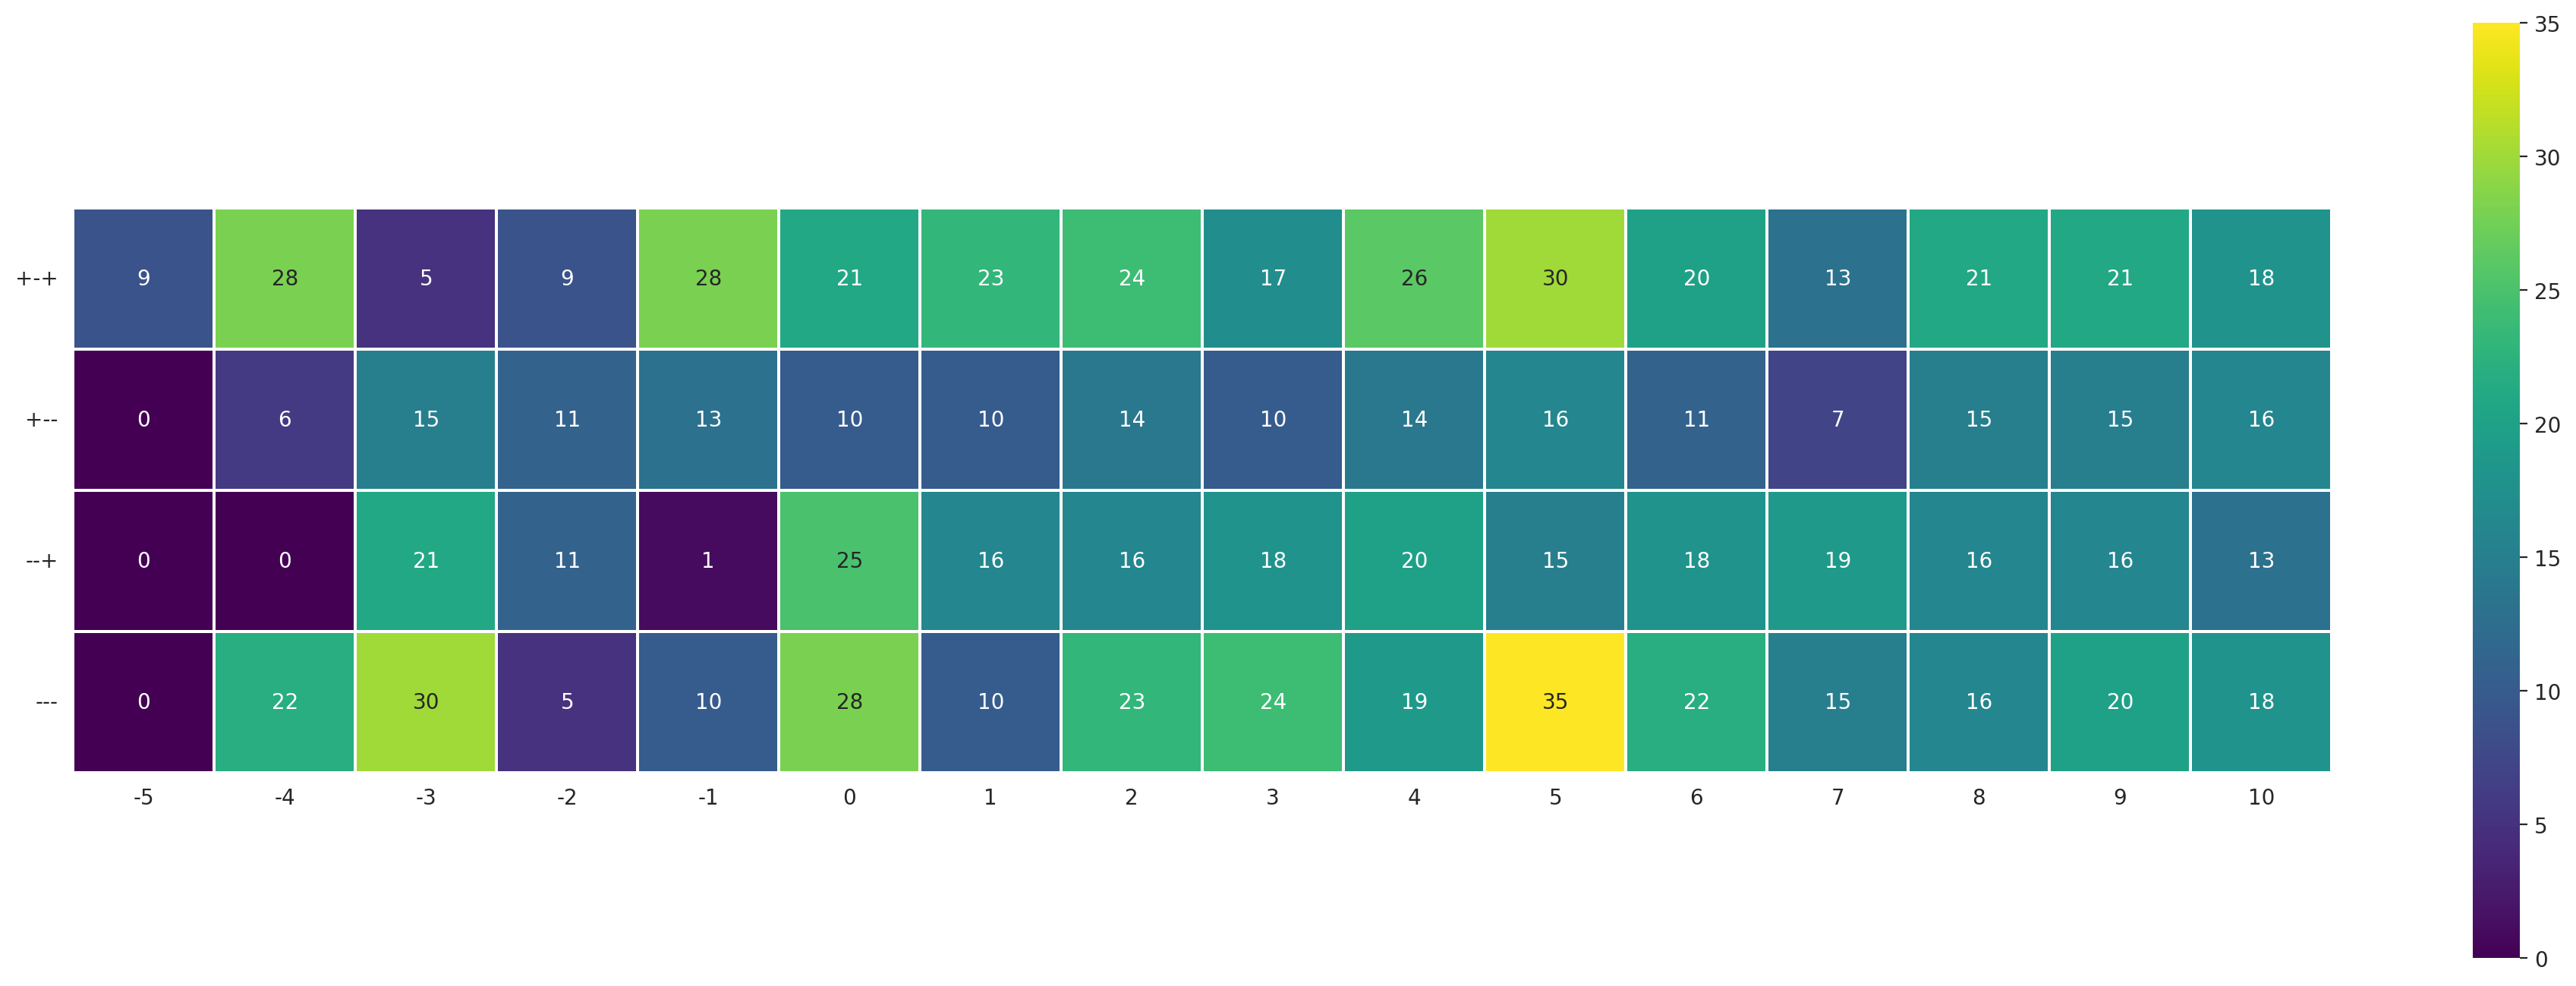

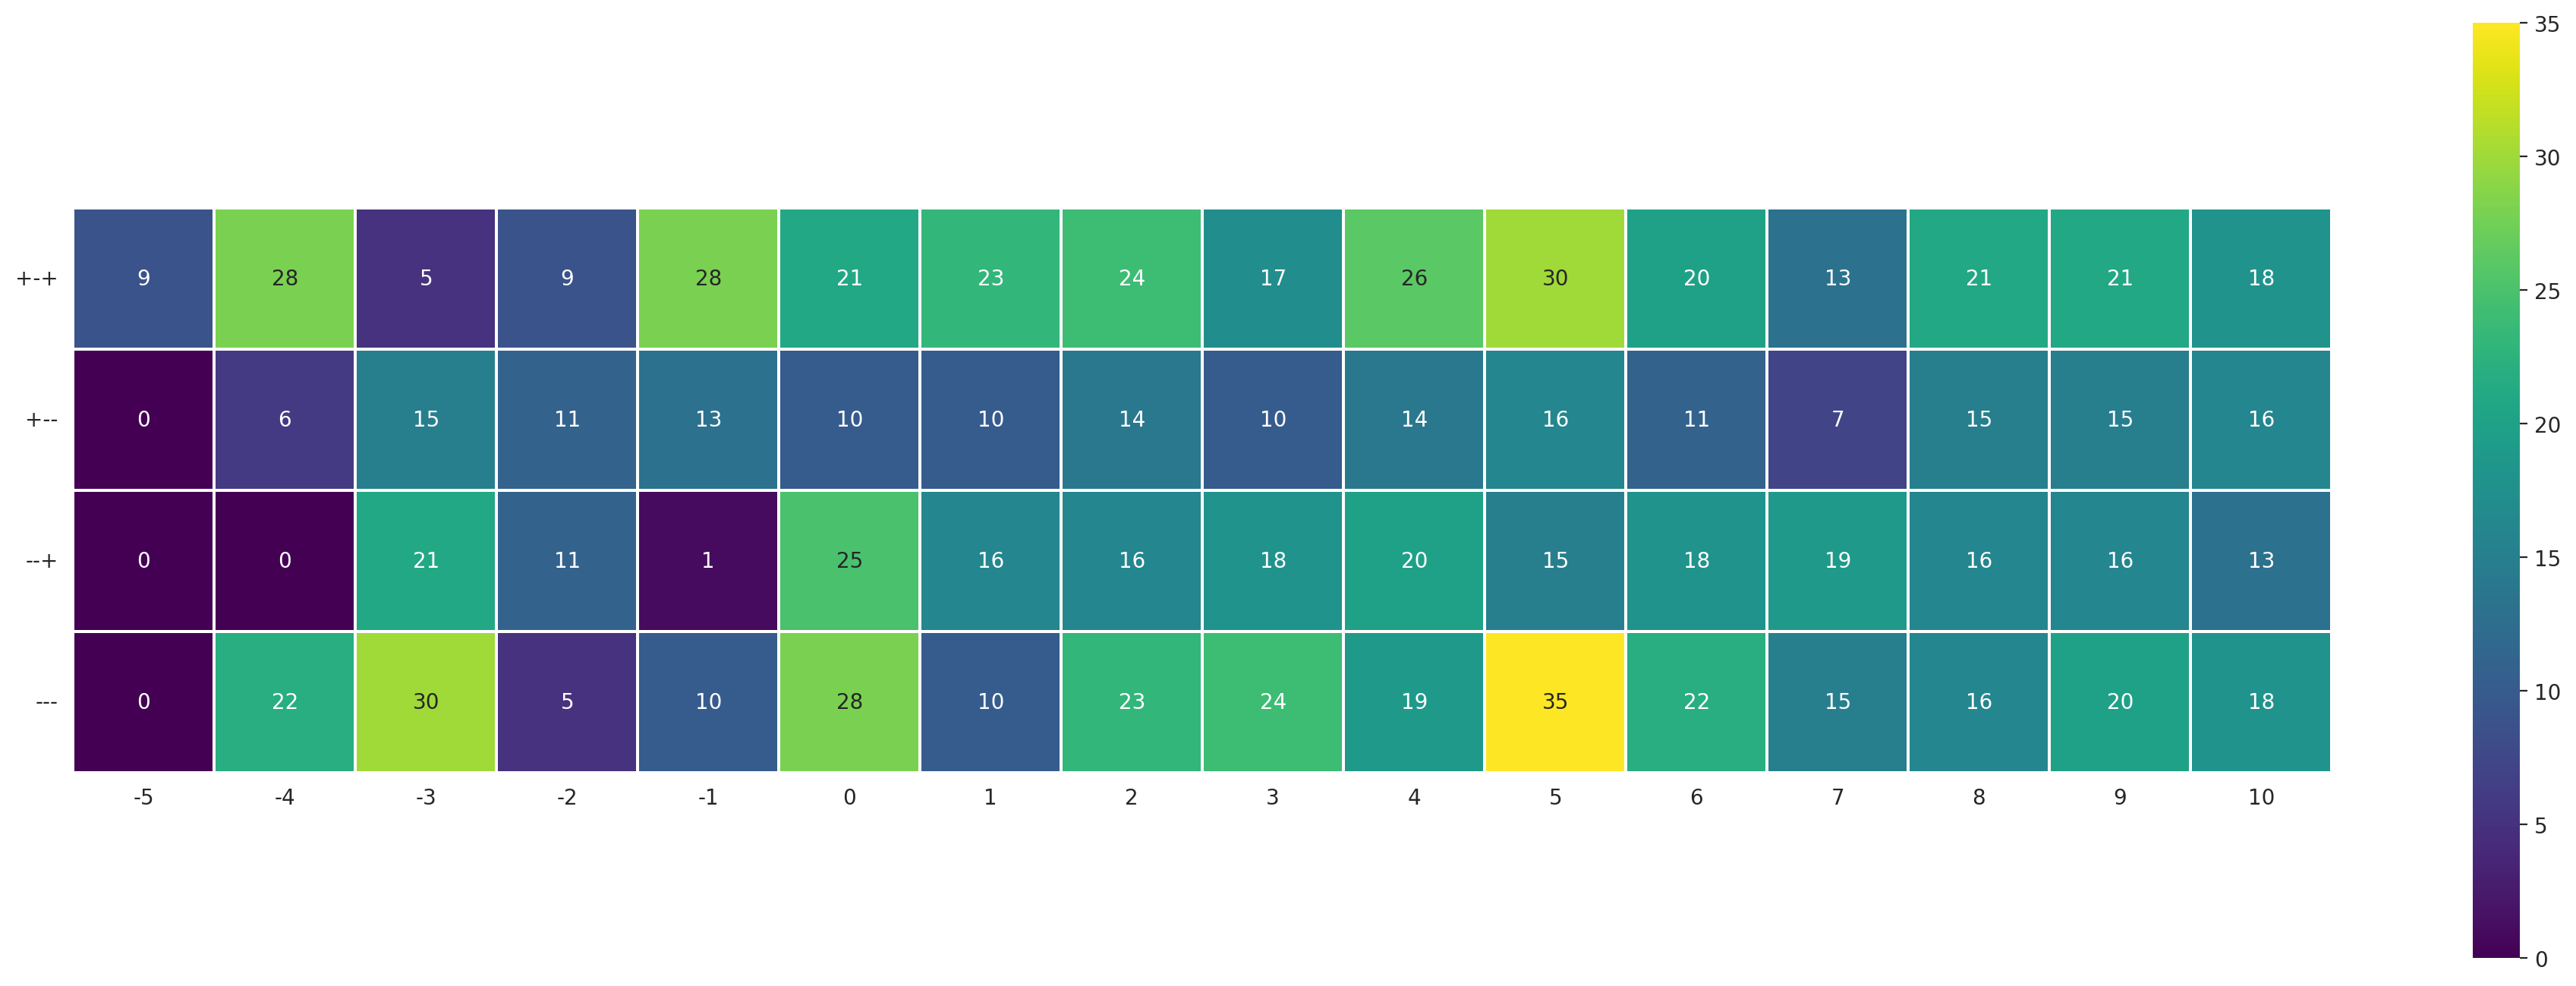

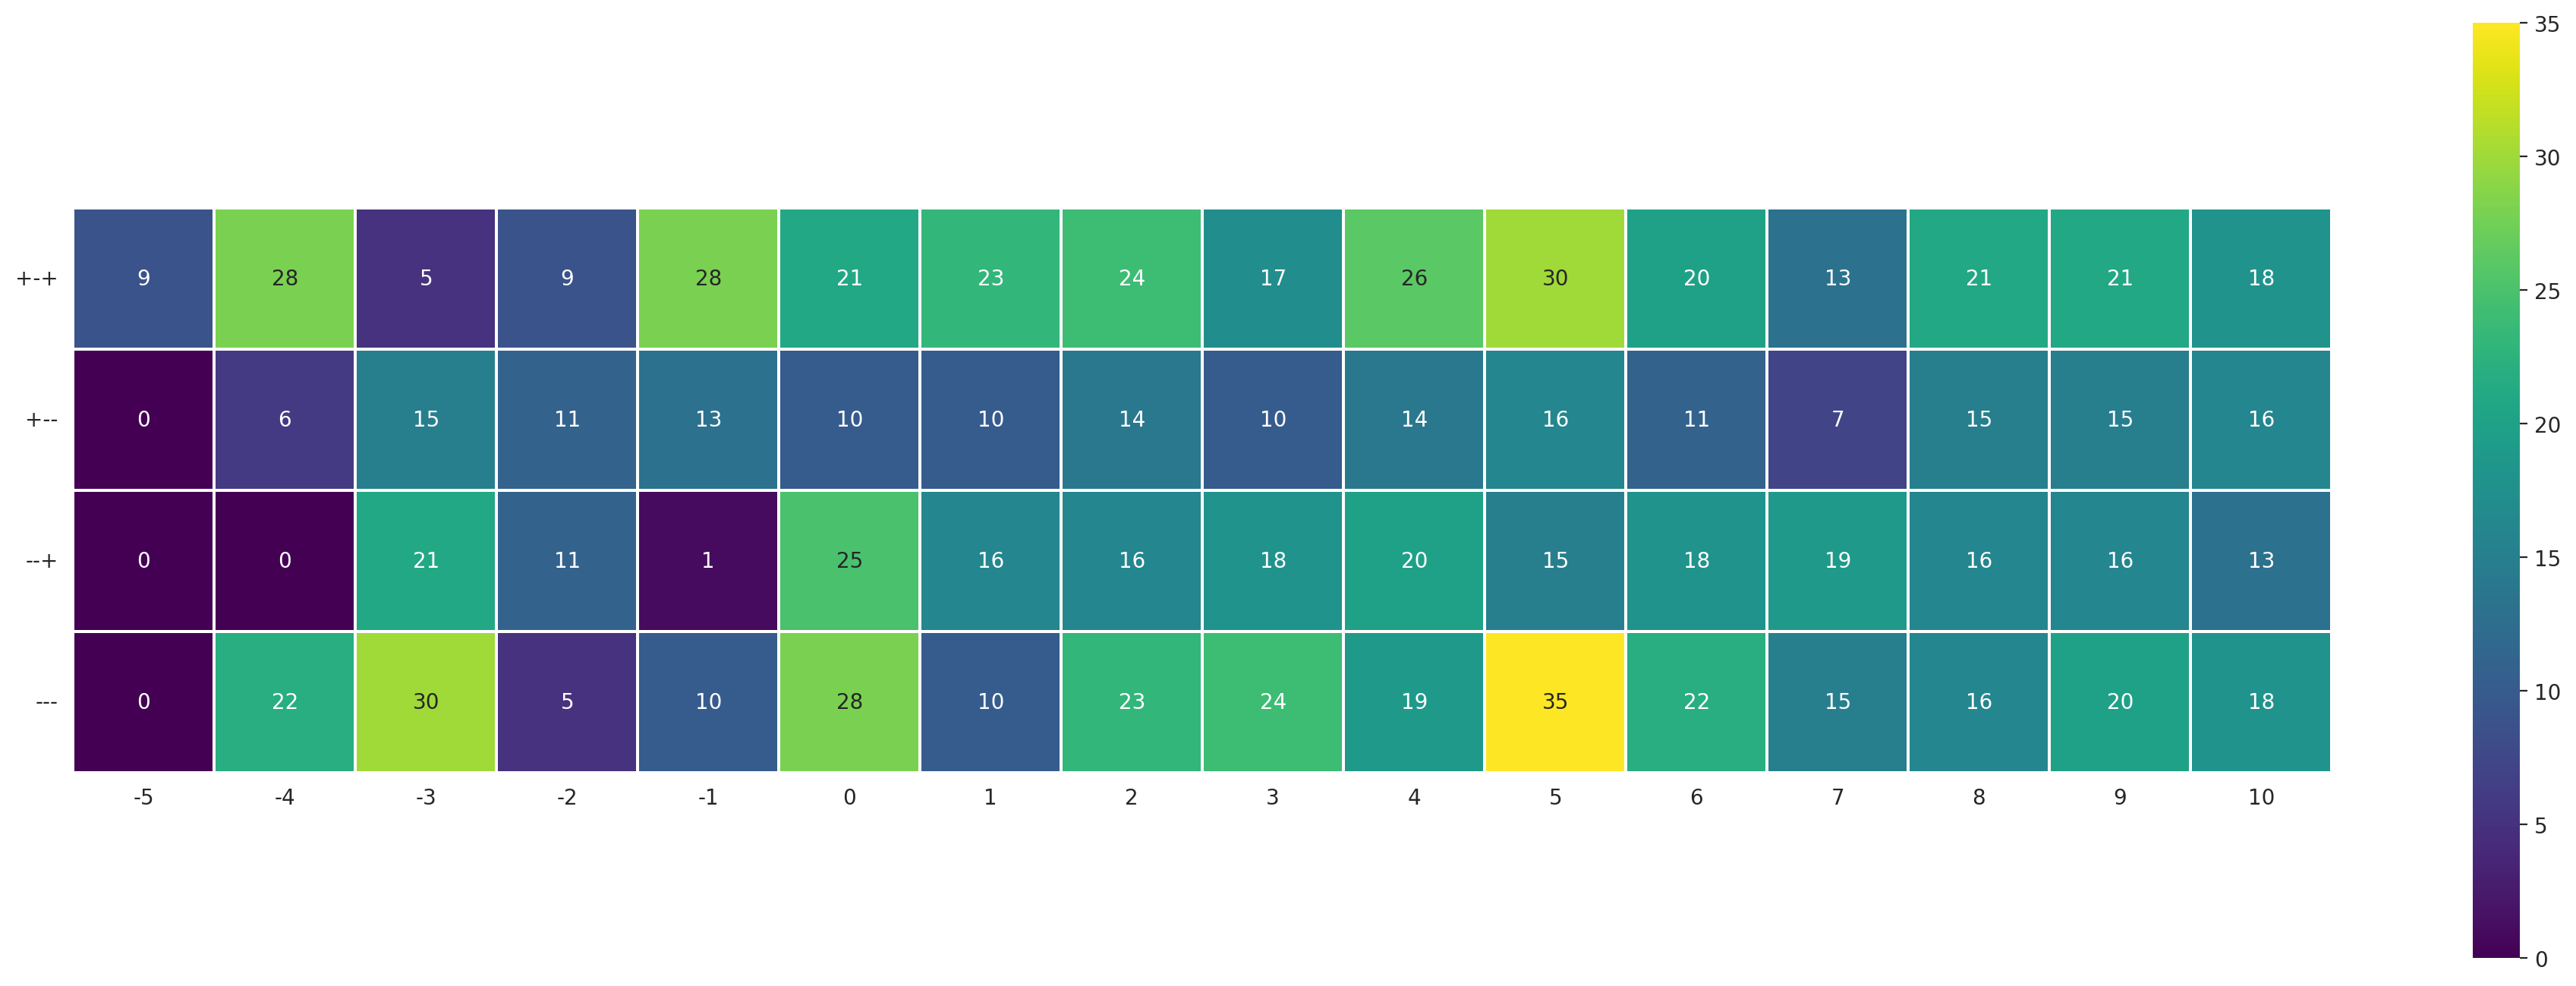

In [12]:
fig=plt.figure(figsize=(24,8) , 
#                dpi= 300, 
               facecolor='w', edgecolor='k')
# df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T.applymap(lambda x: -np.log10(x))

df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T

fig = sns.heatmap(df_plot, 
#                    center=0, 
#                    cmap="vlag",
                   cmap="viridis",
#                    vmin=-1,
                   annot=True,
                square=True,
                   linewidths=.75, )

fig.set(xlabel="", ylabel="")
# fig.xaxis.tick_top()
fig.tick_params(top=False)
plt.yticks(rotation=0) 

In [13]:
CESeek_obj.double_motif_enrichment(*preferred_motif_set_name, strand1="+", strand2="-", spacing=-4)

np.float64(0.9994041365639006)

In [14]:
dict_temp = OrderedDict({
preferred_motif_set_name: {(strand1, strand2): {} for strand1 in ["+", "-"] for strand2 in ["+", "-"]}
})
for strand1 in ["+", "-"]:
    for strand2 in ["+", "-"]:
        for spacing in range(-5,10+1):
            key = (strand1, strand2)
            p_value=CESeek_obj.double_motif_enrichment(*preferred_motif_set_name, strand1=strand1, strand2=strand2, spacing=spacing)
            dict_temp[preferred_motif_set_name][key][spacing] = p_value

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '+-+'),
  Text(0, 1.5, '+--'),
  Text(0, 2.5, '--+'),
  Text(0, 3.5, '---')])

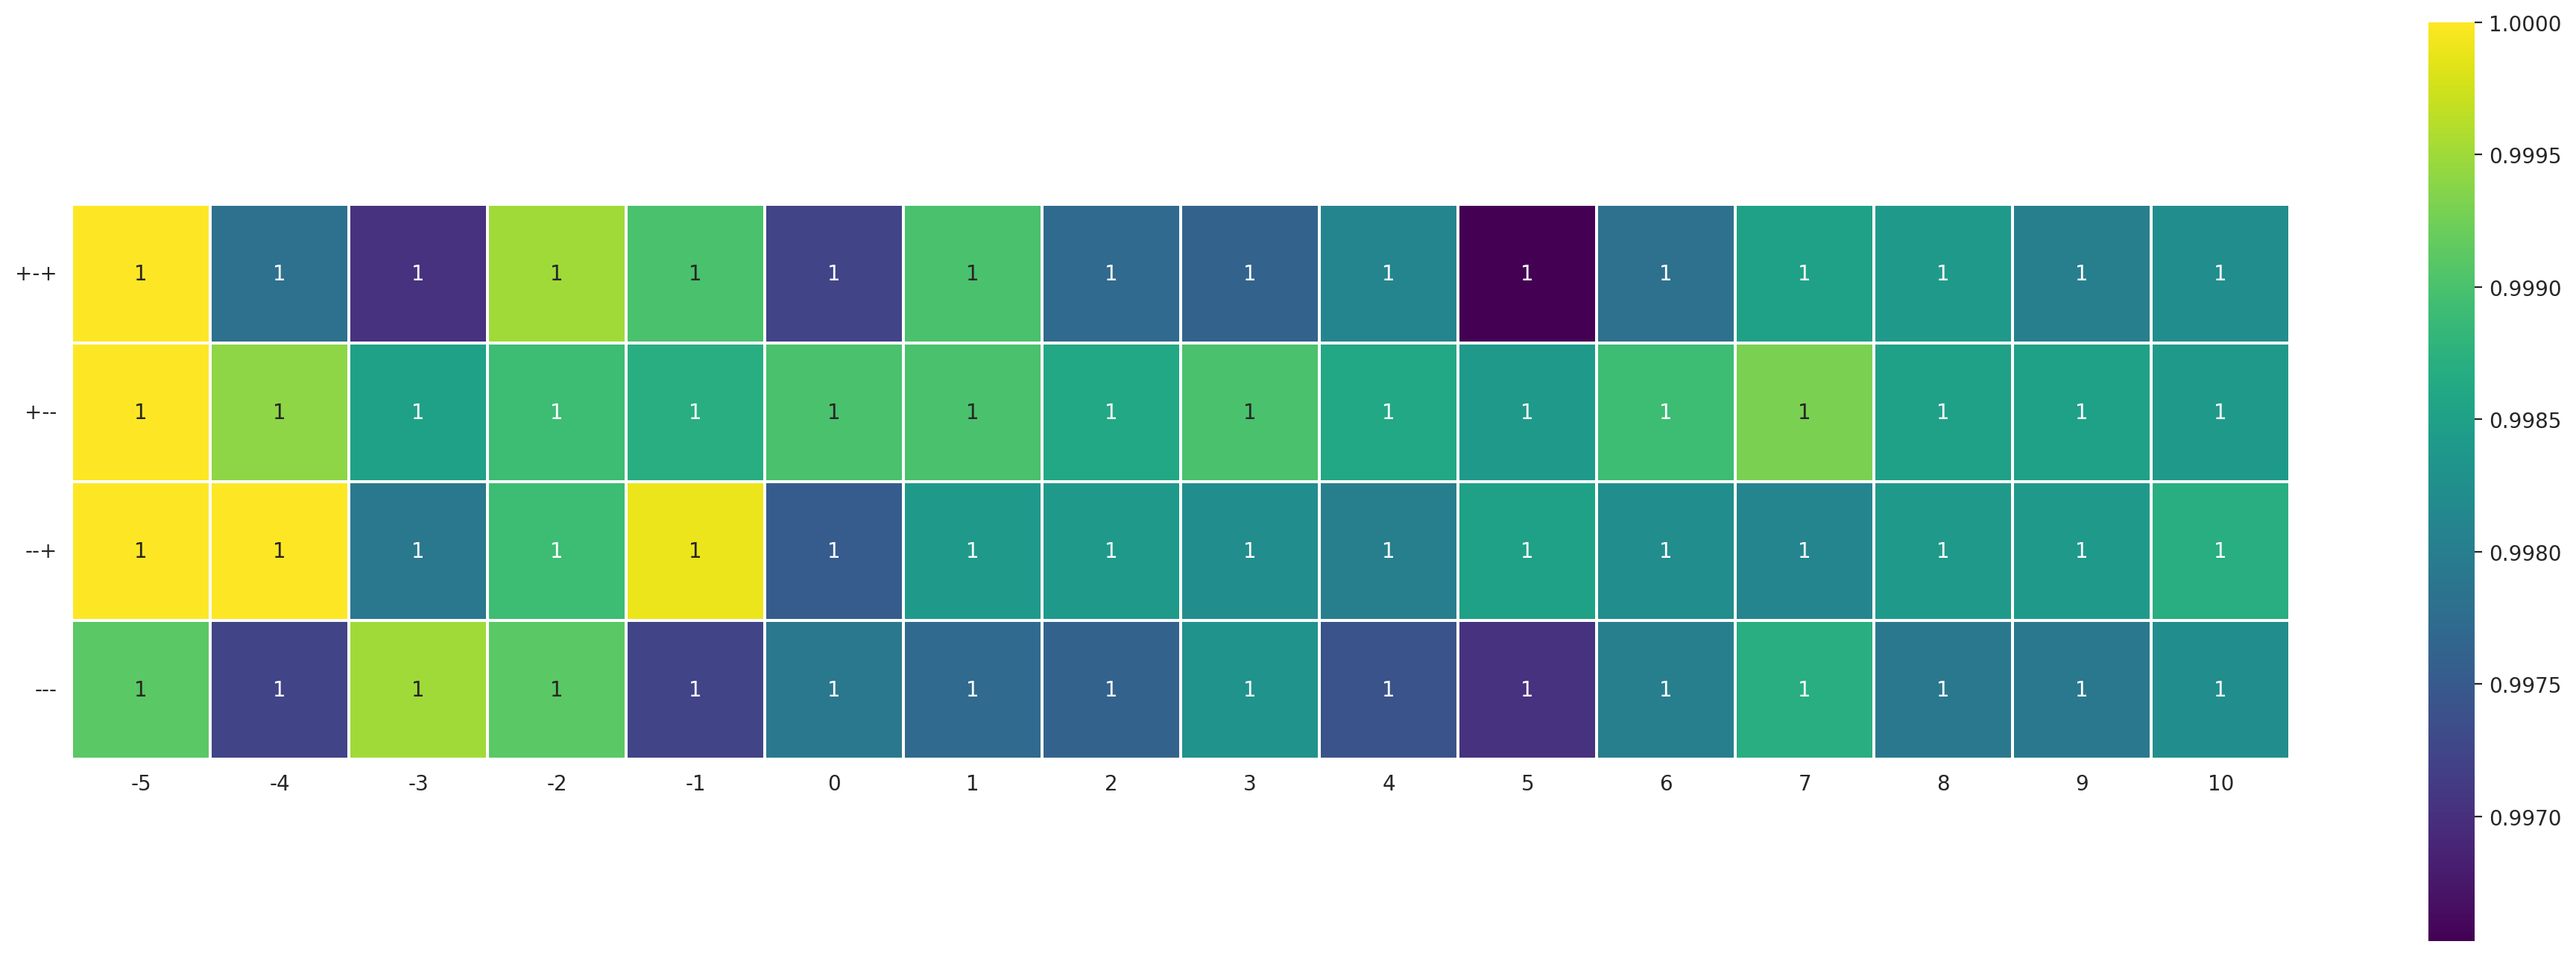

In [15]:
fig=plt.figure(figsize=(24,8) , 
#                dpi= 300, 
               facecolor='w', edgecolor='k')
# df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T.applymap(lambda x: -np.log10(x))

df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T

fig = sns.heatmap(df_plot, 
#                    center=0, 
#                    cmap="vlag",
                   cmap="viridis",
#                    vmin=-1,
                   annot=True,
                square=True,
                   linewidths=.75, )

fig.set(xlabel="", ylabel="")
# fig.xaxis.tick_top()
fig.tick_params(top=False)
plt.yticks(rotation=0) 

In [16]:
dict_temp = CESeek_obj.dominant_CE_configuration(*preferred_motif_set_name)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '+-+'),
  Text(0, 1.5, '+--'),
  Text(0, 2.5, '--+'),
  Text(0, 3.5, '---')])

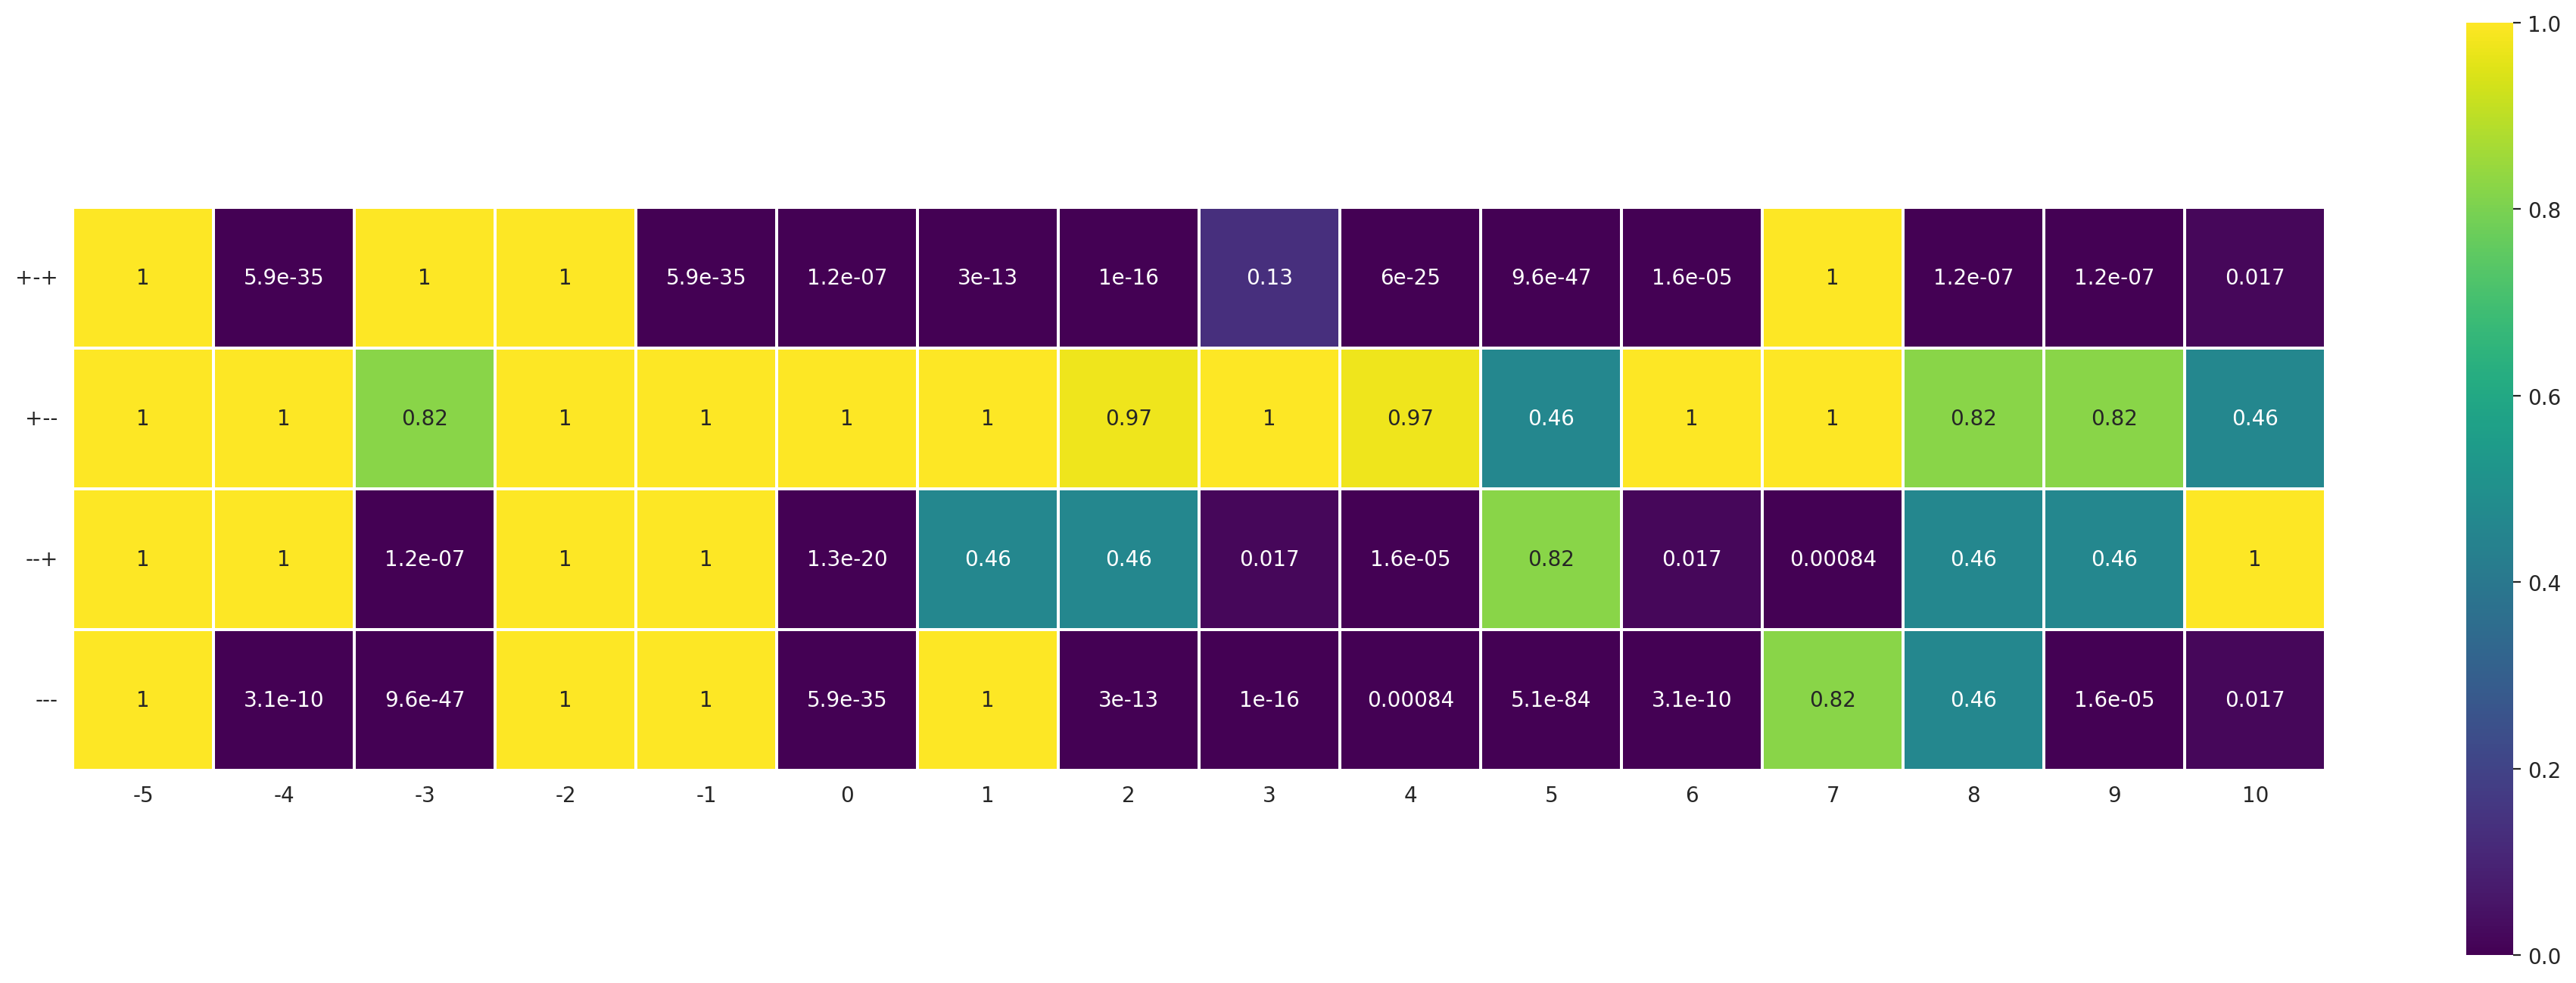

In [17]:
fig=plt.figure(figsize=(24,8) , 
#                dpi= 300, 
               facecolor='w', edgecolor='k')
# df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T.applymap(lambda x: -np.log10(x))

df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T

fig = sns.heatmap(df_plot, 
#                    center=0, 
#                    cmap="vlag",
                   cmap="viridis",
#                    vmin=-1,
                   annot=True,
                square=True,
                   linewidths=.75, )

fig.set(xlabel="", ylabel="")
# fig.xaxis.tick_top()
fig.tick_params(top=False)
plt.yticks(rotation=0) 